## Data Manipulation
### Imports 

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

date_cols = [2, 19, 20, 26]
injuries = pd.read_csv('data/injuries.csv', parse_dates=date_cols)

### Manipulation

In [18]:
injuries_df = injuries.copy() 
injuries_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6541 entries, 0 to 6540
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   PlayerName                  6541 non-null   object        
 1   PlayerId                    6540 non-null   object        
 2   PlayerDOB                   6540 non-null   datetime64[ns]
 3   Height                      6540 non-null   float64       
 4   Weight                      6540 non-null   float64       
 5   Positions                   6540 non-null   object        
 6   GroupPosition               6540 non-null   object        
 7   DraftPick                   5865 non-null   float64       
 8   IsActive                    6540 non-null   object        
 9   FirstSeason                 6541 non-null   int64         
 10  LastSeason                  6541 non-null   int64         
 11  SeasonsPlayed               6541 non-null   int64       

## Adding Cols

In [19]:
start_day = '-10-20' 
injuries_df['approx_first_day'] = pd.to_datetime((injuries_df['FirstSeason'].astype(str) + start_day), format='%Y-%m-%d')

end_day = '-04-15'
injuries_df['approx_last_day'] = pd.to_datetime((injuries_df['LastSeason'].astype(str) + end_day), format='%Y-%m-%d')

remaining_days = injuries_df['approx_last_day'] - injuries_df['DateInjured']
injuries_df['remaining_days'] = (remaining_days / pd.Timedelta(1, 'D')).astype(int)

injuries_df['log_days_injured'] = np.log(injuries_df['DaysInjured'])

age = ((injuries_df['DateInjured'] - injuries_df['PlayerDOB']) / pd.Timedelta(1, 'D'))
injuries_df['age_at_injury'] = age.fillna(-1).astype(int)



### Description 

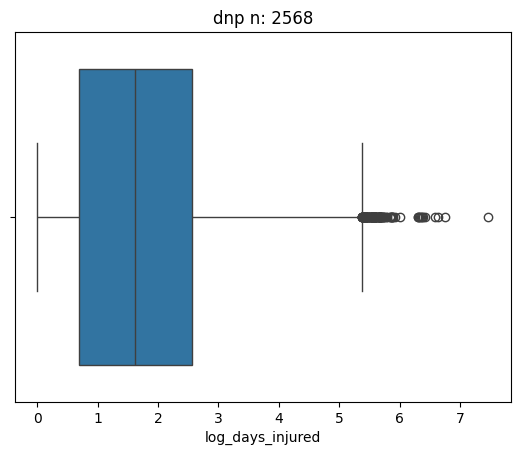

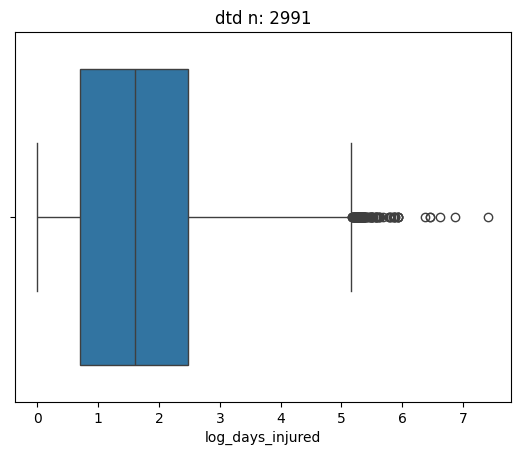

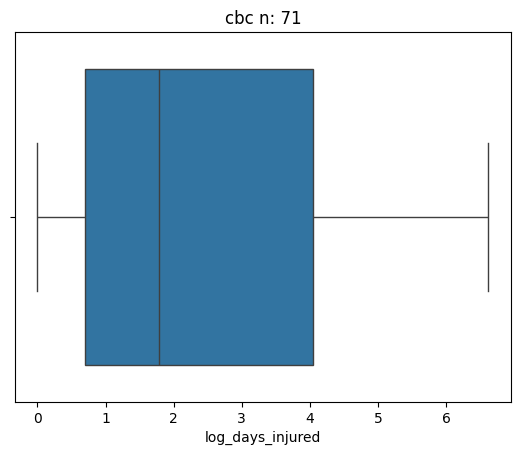

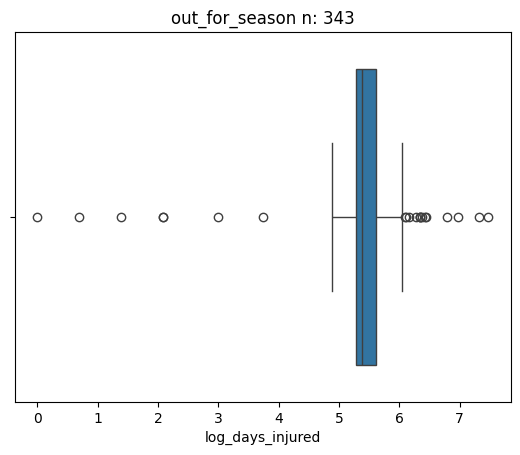

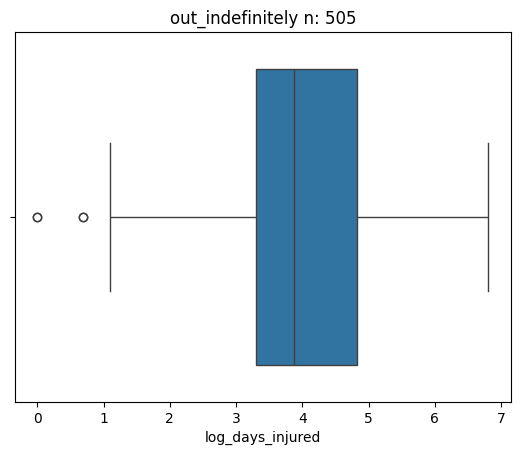

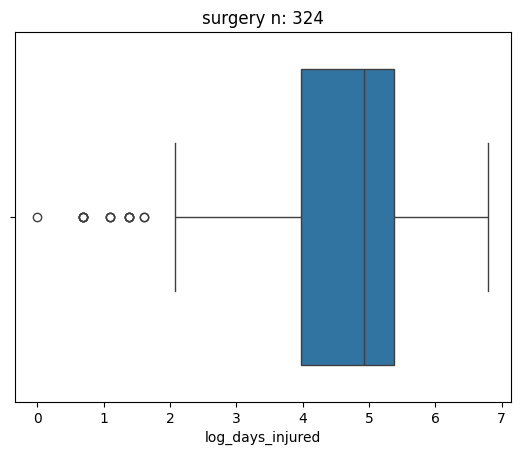

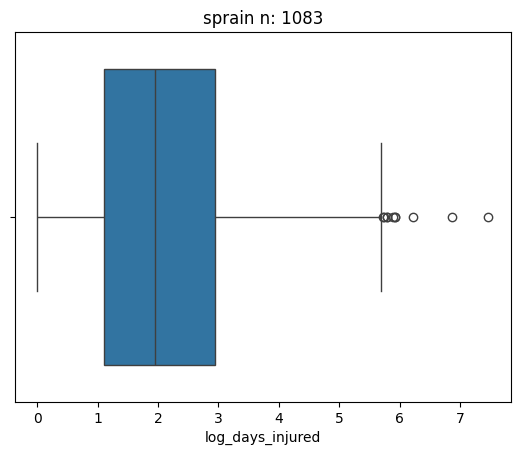

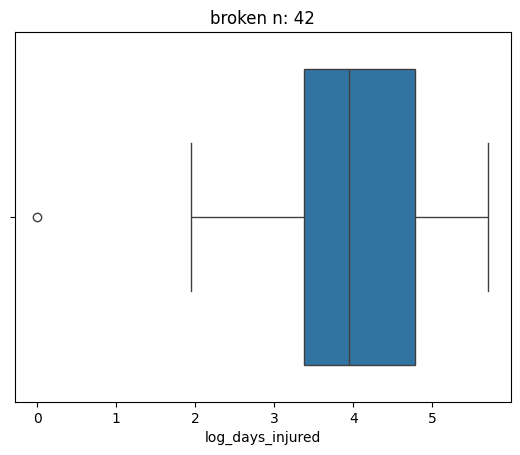

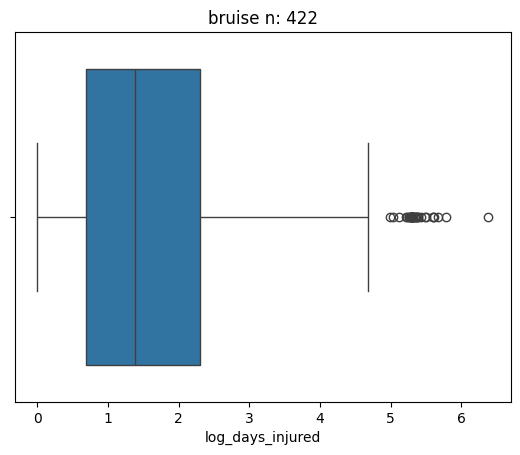

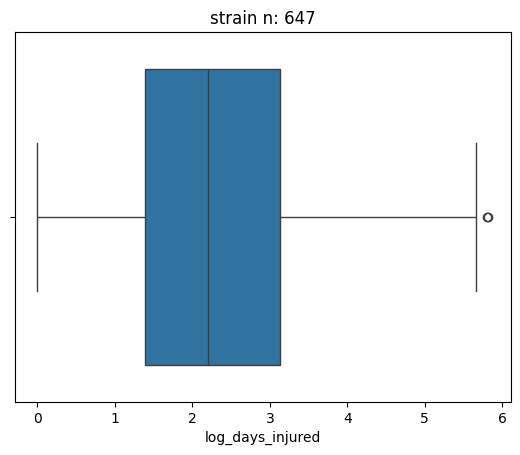

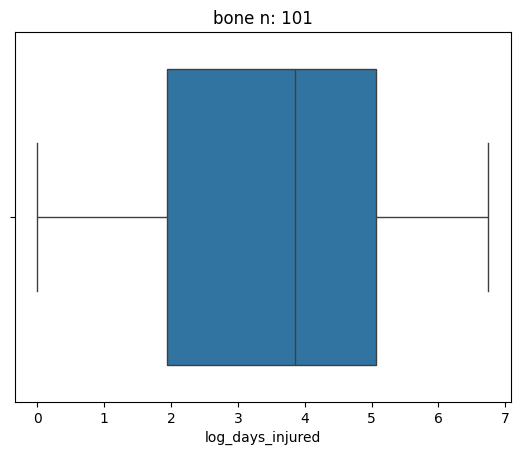

In [20]:

keywords = ['DNP', 'DTD', 'CBC', 'out for season', 'out indefinitely', 'surgery', 'sprain', 'broken', 'bruise', 'strain', 'bone']
col_names = [word.lower().replace(' ', '_') for word in keywords]

for i in range(len(keywords)):
    injuries_df[col_names[i]] = injuries_df['InjuryDescription'].str.contains(keywords[i])

for col in col_names:
    sns.boxplot(data=injuries_df[injuries_df[col]], x='log_days_injured')
    plt.title(col + ' n: ' + str(sum(injuries_df[col])))
    plt.show()


In [21]:
print('Contains Counts')
for col in col_names:
    print(col, sum(injuries_df[col]))


Contains Counts
dnp 2568
dtd 2991
cbc 71
out_for_season 343
out_indefinitely 505
surgery 324
sprain 1083
broken 42
bruise 422
strain 647
bone 101


## Missing Values 


In [22]:
null_counts = injuries_df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

BodyPartInjured               1302
DraftPick                      676
SeasonEndYear                  202
TeamMadePlayoffs               202
TeamLocation                   202
TeamNameFull                   202
GamesMissed                     92
DaysBetweenGames                92
LastTransactionDescription       3
LastTransactionDate              3
LastTransactionType              3
PlayerId                         1
PlayerDOB                        1
IsActive                         1
Height                           1
Weight                           1
Positions                        1
GroupPosition                    1
dtype: int64

This one row has a lot of missing data so I am going to remove it.

In [23]:
injuries_df[injuries_df['PlayerId'].isnull()]


,PlayerName,PlayerId,PlayerDOB,Height,Weight,Positions,GroupPosition,DraftPick,IsActive,FirstSeason,...,dtd,cbc,out_for_season,out_indefinitely,surgery,sprain,broken,bruise,strain,bone
626,Jakob Poeltl,NaN,NaT,NaN,NaN,NaN,NaN,9.0,NaN,2017,...,True,False,False,False,False,True,False,False,False,False


In [24]:
injuries_df = injuries_df.dropna(subset='PlayerId')

Body part injured and draft pick are largest null. The distribution of the target variable for body part injured does seem to be slightly different for null vs not null while for draft pick the difference does not seem too significant. 

I am filling the body part with 'unknown' since this column contains important information.

In [25]:
injuries_df.loc[:, 'BodyPartInjured'] = injuries_df['BodyPartInjured'].fillna('unknown')

## Recoding Bodyparts

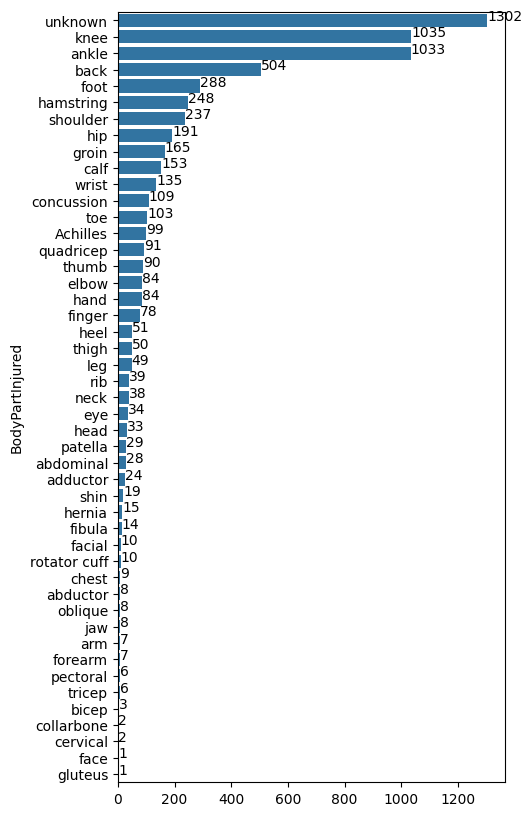

In [26]:
counts = injuries_df['BodyPartInjured'].value_counts()
plt.figure(figsize=(5, 10))
sns.barplot(x=counts.values, y=counts.index)
for i in range(len(counts)): 
    plt.annotate(counts.iloc[i], [counts.iloc[i], i])
plt.show()

In [27]:
# head, face, neck, shoulder, chest, back, arm, elbow, hand, abdomen, hip, leg, heel, knee, ankle, foot
body_part_mapping = {
    'gluteus': 'leg', 
    'cervical': 'neck',
    'collarbone': 'chest', 
    'bicep' : 'arm', 
    'tricep': 'arm',
    'pectoral': 'chest',
    'forearm': 'arm', 
    'jaw': 'face',
    'oblique': 'abdomen', 
    'abductor': 'leg', 
    'rotator cuff': 'shoulder', 
    'facial': 'face', 
    'fibula': 'leg', 
    'hernia': 'abdomen', 
    'shin': 'leg', 
    'adductor': 'leg', 
    'abdominal': 'abdomen', 
    'patella': 'knee', 
    'eye': 'face', 
    'rib': 'chest',
    'thigh': 'leg',
    'finger': 'hand', 
    'thumb': 'hand',
    'quadricep': 'leg',
    'Achilles': 'heel',
    'toe': 'foot', 
    'concussion': 'head',
    'wrist': 'hand', 
    'calf': 'leg', 
    'groin': 'leg',
    'hamstring': 'leg'
}
injuries_df['main_body_part'] = injuries_df['BodyPartInjured'].replace(body_part_mapping)

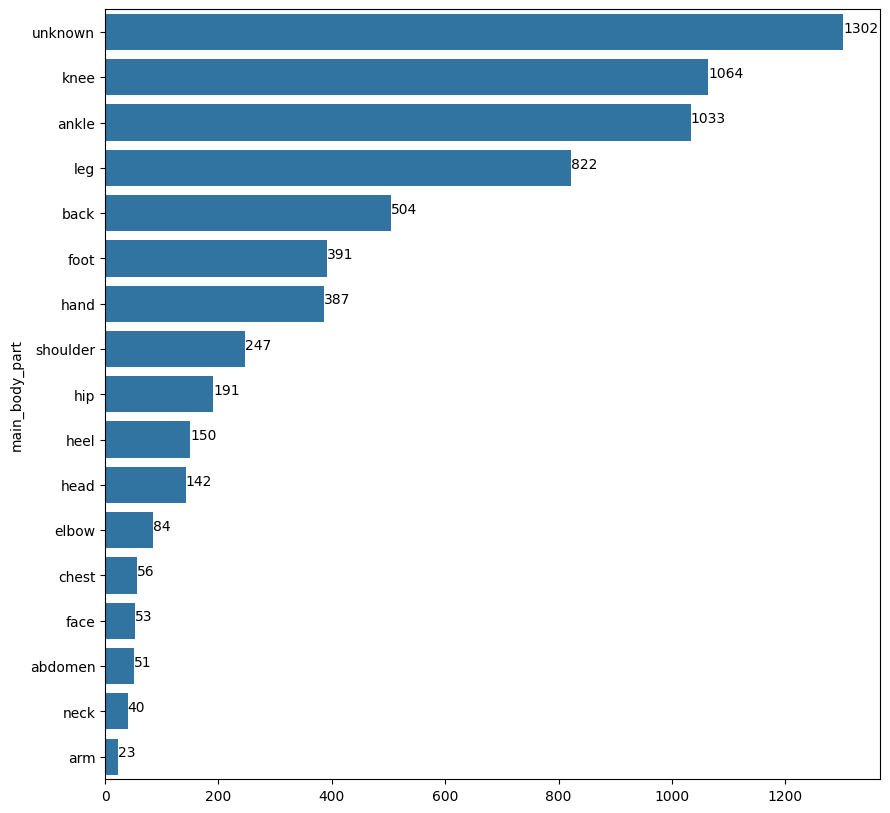

In [28]:
counts = injuries_df['main_body_part'].value_counts()
plt.figure(figsize=(10, 10))
sns.barplot(x=counts.values, y=counts.index)
for i in range(len(counts)): 
    plt.annotate(counts.iloc[i], [counts.iloc[i], i])
plt.show()

### Export

In [29]:
injuries_df.to_csv('data/injuries_cleaned.csv', index=False)